In [17]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn

from skimage import io
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

random_state = 42
gen = random.Random(random_state)

trimmed = False
max_w = 1165 if not trimmed else 643# Measured
data_dir = '../../allwavs/allvowl/extracted/' + 'trimmed/'*trimmed + 'img/'
files = os.listdir(data_dir)
use_mel = True
files = [file for file in files if ('mel' in file) == use_mel]
gen.shuffle(files)

In [18]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
    return

In [19]:
class SpectrumDataset(Dataset):
    def __init__(self, data_dir, files):
        self.data_dir = data_dir
        self.files = [file for file in files if '~' not in file.split('__')[0]]
        gen.shuffle(self.files)
        self.idx2lbl = ['2', '9', 'a', 'E', 'e', 'i', 'o', 'O', 'u', 'y']
        self.lbl2idx = {label: i for i, label in enumerate(self.idx2lbl)}

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_np = io.imread(self.data_dir + '/' + self.files[idx], as_gray=True)
        image_np = np.pad(1 - image_np, [(0, 0), (0, max_w - image_np.shape[1])], mode='constant', constant_values=0)
        label = self.files[idx].split('__')[0].replace('E+', 'E').replace('@', '9')
        return (torch.tensor(image_np).float(), self.lbl2idx[label])

l = len(files)
train_size = 0.9
cutoff = int(l*train_size)

train_set = SpectrumDataset(data_dir, files[:cutoff])
test_set = SpectrumDataset(data_dir, files[cutoff:])

Text(0.5, 1.0, '6')

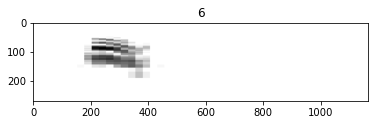

In [20]:
im, label = train_set[0]
plt.imshow(im.numpy(), cmap='gray')
plt.title(label)

In [30]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNClassifier, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3),
                                        nn.ReLU(),
                                        #nn.BatchNorm2d(16),
                                        nn.MaxPool2d(kernel_size=3))
        self.cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3),
                                        nn.ReLU(),
                                        #nn.BatchNorm2d(32),
                                        nn.MaxPool2d(kernel_size=3))
        self.dropout = nn.Dropout(0.5)
        self.linear_layer1 = nn.Sequential(nn.Linear(32*29*(70 if trimmed else 128), 64),
                                           nn.ReLU())
        self.linear_layer2 = nn.Sequential(nn.Linear(64, num_classes))
        
        #self.cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5, padding=2),
        #                                nn.ReLU(),
        #                                #nn.BatchNorm2d(16),
        #                                nn.MaxPool2d(kernel_size=5))
        #self.cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, padding=2),
        #                                nn.ReLU(),
        #                                #nn.BatchNorm2d(32),
        #                                nn.MaxPool2d(kernel_size=5))
        #self.linear_layer1 = nn.Linear(32*10*25, num_classes)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        out1 = self.cnn_layer1(x)
        out2 = self.cnn_layer2(out1)
        #out2 = self.dropout(out2)
        out_vec = out2.reshape(out2.shape[0], -1)
        out = self.linear_layer1(out_vec)
        #out2 = self.linear_layer2(out)
        return out#2

In [31]:
def eval_cnn_classifier(model, eval_dataloader):
    model.eval() 
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            images = images.cuda()
            labels = labels.cuda()
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
    model_tr = copy.deepcopy(model)
    model_tr.train()
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    loss_all_epochs = []
    test_acc_all_epochs = []

    if verbose:
        print(f'Epoch [0/{num_epochs}], Loss: N/A, Test acc: {eval_cnn_classifier(model_tr, test_dataloader):.4f}%')
    
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        for batch_index, (images, labels) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            images = images.cuda()
            labels = labels.cuda()
            pred_labels = model_tr(images)

            loss = loss_fn(pred_labels, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_current_epoch += loss.item()
        
        loss_all_epochs.append(loss_current_epoch)
        test_acc = eval_cnn_classifier(model_tr, test_dataloader)
        test_acc_all_epochs.append(test_acc)
        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_current_epoch:.4f}, Test acc: {test_acc:.4f}%')
        
    return model_tr, loss_all_epochs, test_acc_all_epochs

In [ ]:
batch_size = 1
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)

num_classes = 10
model = CNNClassifier(num_classes)

print('Total number of parameters: ', 
      sum(p.numel() for p in model.parameters()))

torch.manual_seed(0)
model.apply(init_weights)

num_epochs = 50
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01

model.cuda()
model, loss_total, test_acc_total = training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True)

torch.save(model.state_dict(), 'model_cnn_classif.pt')
plt.plot(loss_total, label='loss')
plt.plot([max(loss_total)*(100-x)/100 for x in test_acc_total], label='acc')
plt.legend()
plt.show()

Total number of parameters:  7607690


  0%|▎                                                                                                          | 3/1132 [00:00<00:50, 22.55it/s]

Epoch [0/50], Loss: N/A, Test acc: 0.0000%


  0%|▍                                                                                                          | 4/1132 [00:00<00:30, 36.86it/s]

Epoch [1/50], Loss: 3960.8211, Test acc: 14.2857%


  0%|▍                                                                                                          | 4/1132 [00:00<00:32, 34.98it/s]

Epoch [2/50], Loss: 3049.8392, Test acc: 28.5714%


  0%|▍                                                                                                          | 4/1132 [00:00<00:34, 32.65it/s]

Epoch [3/50], Loss: 2309.6128, Test acc: 35.2941%


  0%|▍                                                                                                          | 5/1132 [00:00<00:29, 38.11it/s]

Epoch [4/50], Loss: 1844.0605, Test acc: 49.5798%


  0%|▍                                                                                                          | 4/1132 [00:00<00:33, 33.53it/s]

Epoch [5/50], Loss: 1377.4988, Test acc: 50.4202%


  0%|▍                                                                                                          | 4/1132 [00:00<00:31, 35.45it/s]

Epoch [6/50], Loss: 1123.8291, Test acc: 42.8571%


  0%|▎                                                                                                          | 3/1132 [00:00<00:42, 26.87it/s]

Epoch [7/50], Loss: 793.4097, Test acc: 50.4202%


  0%|▍                                                                                                          | 4/1132 [00:00<00:30, 36.94it/s]

Epoch [8/50], Loss: 567.0167, Test acc: 62.1849%


  0%|▍                                                                                                          | 4/1132 [00:00<00:35, 31.88it/s]

Epoch [9/50], Loss: 399.1148, Test acc: 62.1849%


  0%|▎                                                                                                          | 3/1132 [00:00<00:39, 28.29it/s]

Epoch [10/50], Loss: 330.0544, Test acc: 64.7059%


  8%|████████▌                                                                                                 | 91/1132 [00:02<00:28, 36.60it/s]

In [ ]:
acc = eval_cnn_classifier(model, test_dataloader)
print(acc)